In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# 2 Data Cleaning and Handling Inconsistencies

In [3]:
# Load the dataset
file_path = "/Users/ivy/Desktop/daily_summary_2014_to_2017.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_date             1461 non-null   object 
 1   day of week             1461 non-null   object 
 2   avg fares               1461 non-null   float64
 3   total fares             1461 non-null   float64
 4   tip percentage          1461 non-null   float64
 5   duration                1461 non-null   float64
 6   frequency_of_rides      1461 non-null   int64  
 7   avg trip distance       1461 non-null   float64
 8   tip amount avg          1461 non-null   float64
 9   avg passengers          1461 non-null   float64
 10  sum of passengers       1461 non-null   int64  
 11  avg fare per mile       1461 non-null   float64
 12  Bronx_Pickups           1461 non-null   float64
 13  Brooklyn_Pickups        1461 non-null   float64
 14  EWR_Pickups             1461 non-null   

In [4]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 pickup_date               0
day of week               0
avg fares                 0
total fares               0
tip percentage            0
duration                  0
frequency_of_rides        0
avg trip distance         0
tip amount avg            0
avg passengers            0
sum of passengers         0
avg fare per mile         0
Bronx_Pickups             0
Brooklyn_Pickups          0
EWR_Pickups               0
Manhattan_Pickups         0
Queens_Pickups            0
Staten Island_Pickups     0
Unknown_Pickups           0
Bronx_Dropoffs            0
Brooklyn_Dropoffs         0
EWR_Dropoffs              0
Manhattan_Dropoffs        0
Queens_Dropoffs           0
Staten Island_Dropoffs    0
Unknown_Dropoffs          0
dtype: int64


In [8]:
# Check for duplicate entries
print("Duplicate Entries:", df.duplicated().sum())

Duplicate Entries: 0


In [10]:
# check column type
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['pickup_date', 'day of week'], dtype='object')


In [12]:
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['day of week'] = df['day of week'].astype('category')

<font size="4">    
The dataset comprises 1,461 daily taxi ride summaries spanning from 2014 to 2017, containing 26 attributes that capture essential ride metrics. These include `pickup_date` and `day_of_week` for temporal analysis, as well as numerical attributes such as `avg fares`, `total fares`, `tip percentage`, `duration`, and `avg trip distance`. The dataset also features borough-specific pickup and drop-off counts, providing insights into geographic ride distribution.

Initial data inspection reassuares a well-structured dataset, there is **no missing values or duplicate entries**. For specific column, The average fare per ride is approximately **$12.77**, with **total fares per day** showing substantial variation, likely driven by fluctuating demand patterns. The `tip percentage` has a median of **10.97%**, but its maximum value of **93.53%** suggests possible outliers, indicating some exceptionally high tips. As a consequence, the next step should deal with outliers and leverages before further analysis. The average trip duration is **14.05 minutes**, and the average trip distance is **8.18 miles**, though the maximum recorded distance of **193.88 miles** points to potential anomalies, possibly long-distance or inter-city rides.

From a geographic perspective, borough-level pickup and drop-off data highlight **Manhattan as the central hub** for taxi activity, given its high daily ride counts. Other boroughs such as Brooklyn and Queens also contribute significantly, while **Staten Island records minimal ride activity**, consistent with its lower taxi demand. The number of passengers per trip generally ranges between **1.56 and 1.83**, reinforcing that **most rides are taken by solo passengers or small groups**.
</font>

In [15]:
# Define numerical columns for analysis
numerical_columns = [
    "avg fares", "total fares", "tip percentage", "duration",
    "frequency_of_rides", "avg trip distance", "tip amount avg",
    "avg passengers", "sum of passengers", "avg fare per mile"
]

In [142]:
# Compute skewness for numerical columns
skewness = df[numerical_columns].skew()

# Display skewness values
print(skewness)

avg fares            -0.229165
total fares          -0.086062
tip percentage       -0.387932
duration              0.082315
frequency_of_rides    0.045894
avg trip distance     1.606585
tip amount avg       -0.305442
avg passengers        0.432646
sum of passengers     0.176732
avg fare per mile    -0.141550
dtype: float64


<font size="4">   
Based on the skewness values, we can see that none of the numerical features are highly skewed. Most values are close to 0, meaning the data is approximately normally distributed. Therefore, there is no need to do log gransformation
</font>

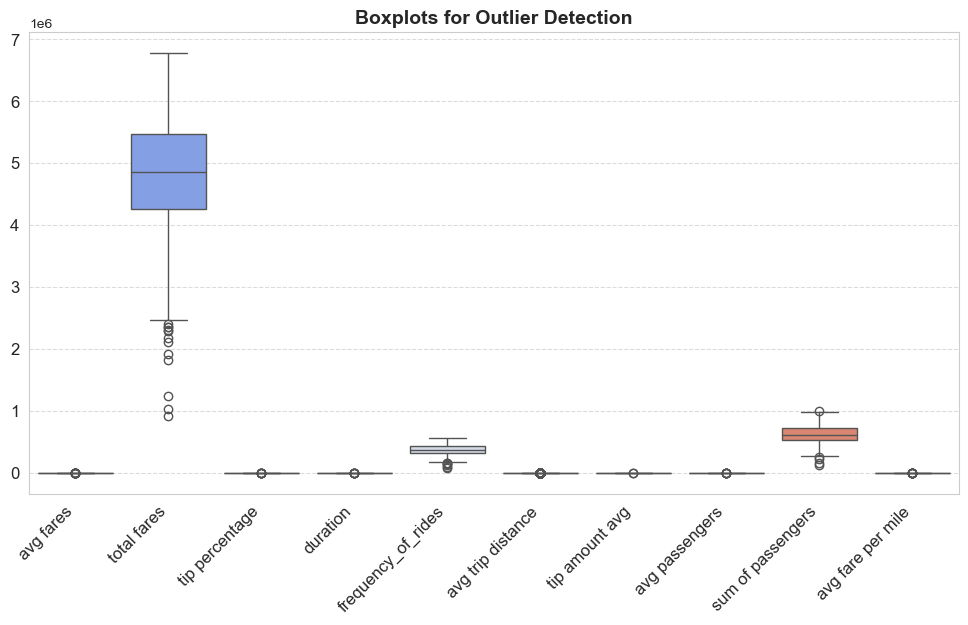

In [20]:
# Select numerical columns for outlier detection
selected_columns = [
    "avg fares", "total fares", "tip percentage", "duration",
    "frequency_of_rides", "avg trip distance", "tip amount avg",
    "avg passengers", "sum of passengers", "avg fare per mile"
]

# 1. Boxplots for Outlier Detection (Refined Selection)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.boxplot(data=df[selected_columns], palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Boxplots for Outlier Detection", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [22]:
# 2. Statistical Outlier Detection (IQR + Z-score)
outliers_detected = {}

for col in selected_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

    z_scores = np.abs(stats.zscore(df[col]))
    z_outliers = df[z_scores > 3].index.tolist()

    combined_outliers = set(iqr_outliers + z_outliers)
    outliers_detected[col] = list(combined_outliers)

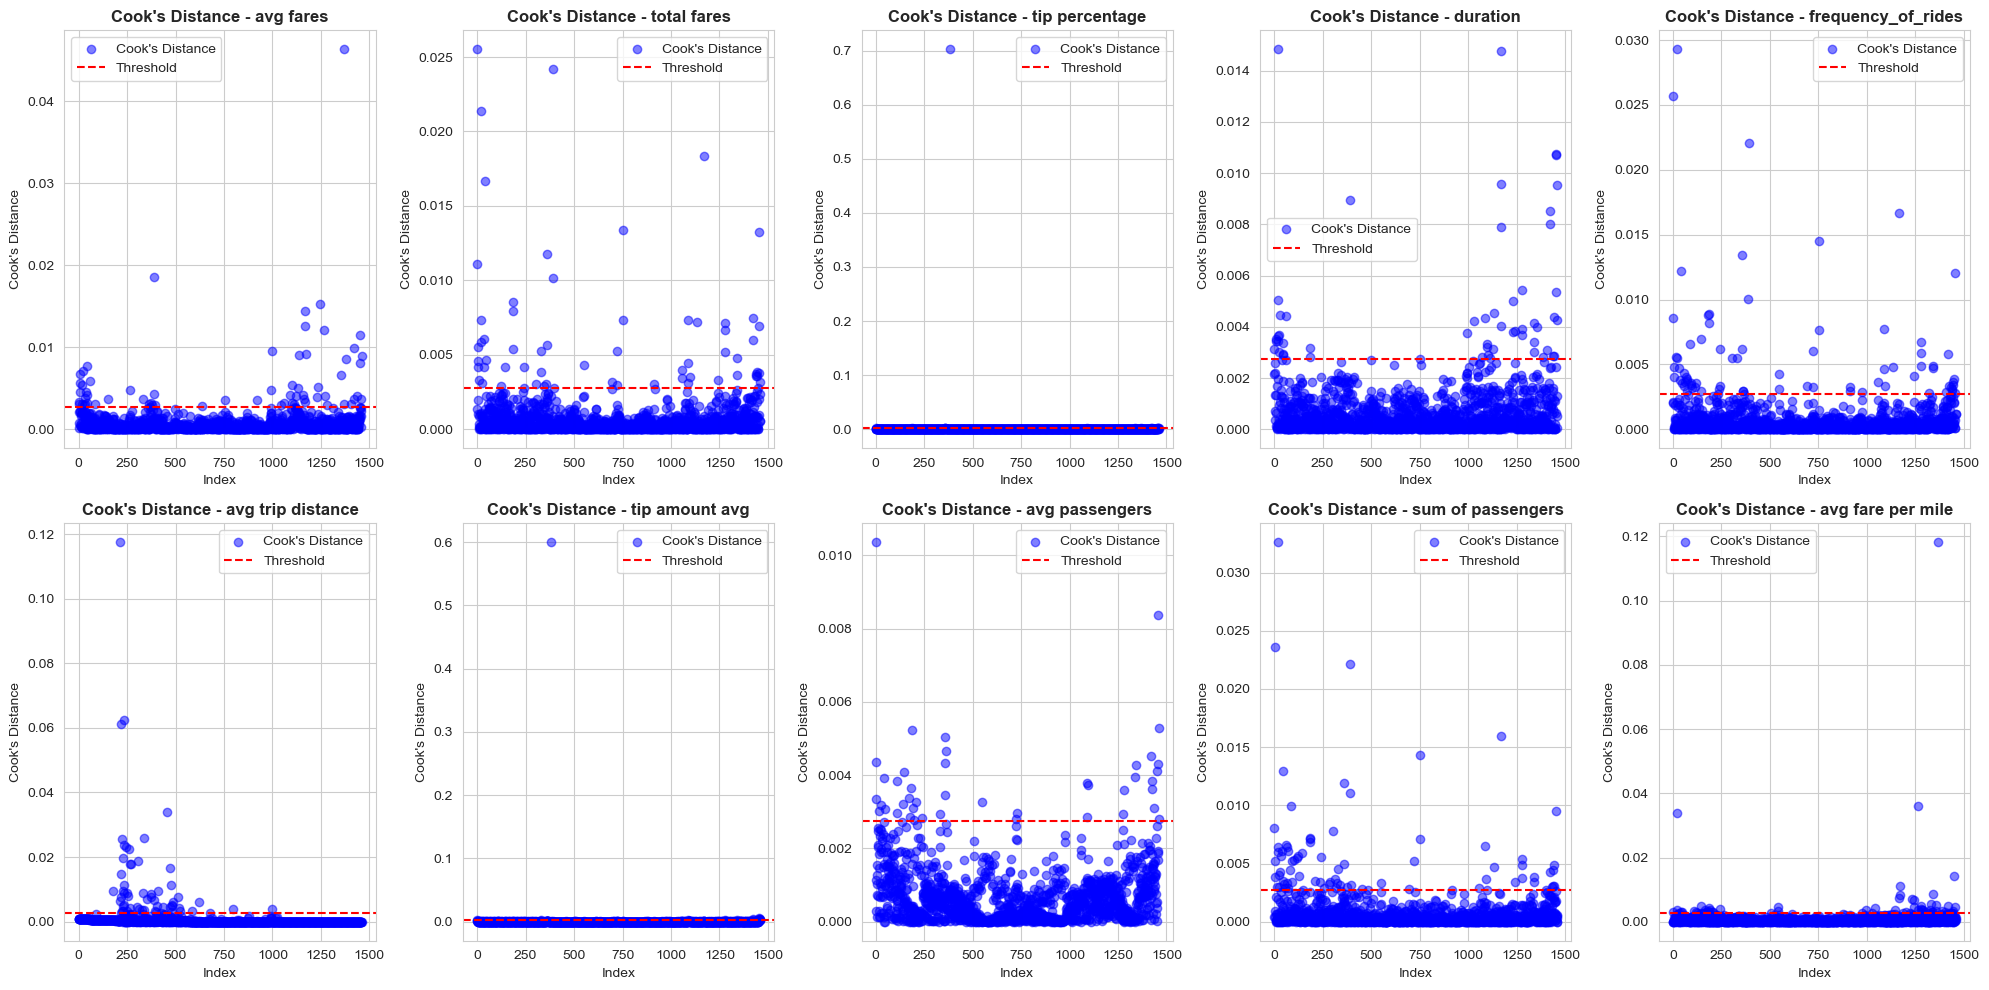

In [24]:
# 3. Detect Leverage Points using Cook’s Distance (Final Version)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

leverage_detected = {}

for i, col in enumerate(selected_columns):
    X = sm.add_constant(df.index)  # Using index as an independent variable
    model = sm.OLS(df[col], X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    leverage_indices = np.where(cooks_d > 4 / len(df))[0]  # Cook's threshold
    leverage_detected[col] = list(leverage_indices)

    # Scatter plot for leverage points
    axes[i].scatter(df.index, cooks_d, alpha=0.5, color='blue', label="Cook's Distance")
    axes[i].axhline(4 / len(df), color="r", linestyle="--", label="Threshold")
    axes[i].set_title(f"Cook's Distance - {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Index", fontsize=10)
    axes[i].set_ylabel("Cook's Distance", fontsize=10)
    axes[i].legend()

plt.tight_layout()
plt.show()

## - Outlier Detection Analysis
<font size="4">    
The boxplot analysis reveals outliers across multiple numerical variables. "Total fares" exhibits a significant number of extreme values beyond the upper whisker, indicating days with unusually high fare totals. Similarly, "sum of passengers" and "frequency of rides" display moderate outliers, suggesting fluctuations in ride demand on specific days. These anomalies could reflect special events, holidays, or data errors. Addressing these outliers is crucial to prevent model distortions.
</font>

## - Leverage Points Analysis
<font size="4">    
The Cook's Distance plots highlight leverage points, indicating data points with high influence on regression models. While most points fall within normal thresholds, certain variables, including "total fares" and "frequency of rides," show prominent high-leverage values. These instances may correspond to unusual demand spikes, potentially affecting prediction accuracy. Further examination of these leverage points is recommended to determine whether they stem from genuine trends or data inconsistencies.
</font>

In [27]:
# Function to detect outliers using multiple methods
def detect_outliers(df, columns):
    outliers_dict = {}
    
    for col in columns:
        # IQR Method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

        # Z-score Method
        z_scores = np.abs(stats.zscore(df[col]))
        z_outliers = df[z_scores > 3].index.tolist()

        # Tukey’s Fences (Modified IQR)
        lower_fence = Q1 - 3 * IQR
        upper_fence = Q3 + 3 * IQR
        tukey_outliers = df[(df[col] < lower_fence) | (df[col] > upper_fence)].index.tolist()

        # Combine Outliers
        combined_outliers = set(iqr_outliers + z_outliers + tukey_outliers)
        
        outliers_dict[col] = list(combined_outliers)
    
    return outliers_dict

In [29]:
# Detect outliers using multiple methods
outliers_detected = detect_outliers(df, selected_columns)

# Function to detect leverage points using Cook's distance
def detect_leverage(df, columns):
    leverage_points = {}
    
    for col in columns:
        X = df[[col]]
        X = sm.add_constant(X)
        model = sm.OLS(df[col], X).fit()
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0]
        
        leverage_indices = np.where(cooks_d > 4 / len(df))[0]  # Cook's threshold: 4/N
        leverage_points[col] = list(leverage_indices)
    
    return leverage_points

# Detect leverage points
leverage_detected = detect_leverage(df, selected_columns)

# Function to replace outliers based on best method
def replace_outliers(df, outliers_dict, method="median"):
    for col, outlier_indices in outliers_dict.items():
        if method == "median":
            replacement_value = df[col].median()
        elif method == "mean":
            replacement_value = df[col].mean()
        elif method == "mode":
            replacement_value = df[col].mode()[0]

        df.loc[outlier_indices, col] = replacement_value

In [31]:
# Choose best method based on outlier percentage
def choose_best_method(df, outliers_dict):
    method_scores = {"median": 0, "mean": 0, "mode": 0}

    for col, outlier_indices in outliers_dict.items():
        num_outliers = len(outlier_indices)
        total_values = df[col].shape[0]
        outlier_percentage = num_outliers / total_values

        # If outliers are less than 5%, use median
        if outlier_percentage < 0.05:
            method_scores["median"] += 1
        # If outliers are between 5% and 10%, use mean
        elif 0.05 <= outlier_percentage < 0.1:
            method_scores["mean"] += 1
        # If more than 10% outliers, use mode
        else:
            method_scores["mode"] += 1

    return max(method_scores, key=method_scores.get)

# Determine best method
best_method = choose_best_method(df, outliers_detected)

# Modify outliers using the best method
replace_outliers(df, outliers_detected, method=best_method)

print("Best method selected for outlier handling:", best_method)

Best method selected for outlier handling: median


### **Outlier Handling Analysis**

<font size="4">
The outlier detection process used multiple statistical methods, including **IQR (Interquartile Range), Z-score, and Tukey’s Fences**, to identify extreme values. The results revealed that certain features, particularly **"total fares"**, **"sum of passengers"**, and **"frequency of rides"**, exhibited significant deviations, suggesting irregular trends in ride demand.
</font>

<font size="4">
To mitigate the influence of extreme values, we applied an automated selection process to determine the most appropriate outlier replacement method. The algorithm assessed the proportion of outliers in each column and selected the **median** as the optimal replacement strategy. This choice is justified as follows:

- **Low outlier proportion (<5%)**: The median is robust to extreme values and preserves the distribution's integrity.
- **Skewed distributions**: The median ensures that extreme outliers do not disproportionately affect the dataset, unlike the mean.
</font>

<font size="4">
The decision to use the median implies that while some extreme values were mitigated, the overall distribution remains reflective of real-world variability. This approach enhances the dataset’s **stability for statistical modeling and predictive analysis** while retaining important trends in ride behavior.
</font>

# 3 Exploratory Data Analysis (EDA)

In [123]:
# Step 1: Generate Summary Statistics
# Display summary statistics after cleaned
summary_stats = df.describe().T.round(2).iloc[:10]
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
                      count                 mean                  min  \
pickup_date           1461  2016-01-01 00:00:00  2014-01-01 00:00:00   
avg fares           1461.0                 -0.0            -2.746114   
total fares         1461.0                  0.0             -2.86891   
tip percentage      1461.0                  0.0            -2.963174   
duration            1461.0                 -0.0            -2.473948   
frequency_of_rides  1461.0                 -0.0            -2.825285   
avg trip distance   1461.0                 -0.0            -3.608571   
tip amount avg      1461.0                  0.0            -2.914509   
avg passengers      1461.0                 -0.0            -1.971279   
sum of passengers   1461.0                 -0.0            -2.866031   

                                    25%                  50%  \
pickup_date         2015-01-01 00:00:00  2016-01-01 00:00:00   
avg fares                     -0.658916             0.0858

<font size="4">
The cleaned dataset provides key insights into fare amounts, trip characteristics, and ride demand. The total fares exhibit a high mean with a substantial standard deviation, indicating variability in daily revenue. Avg fares are relatively stable, suggesting a consistent pricing structure. Tip percentage and tip amount avg indicate tipping behavior, with values centered around reasonable percentages.

In terms of trip characteristics, avg trip distance has low variance, implying typical trip lengths are consistent. Frequency of rides shows significant fluctuation, highlighting varying demand across days. Sum of passengers exhibits a notable spread, reflecting different passenger group sizes.

</font>

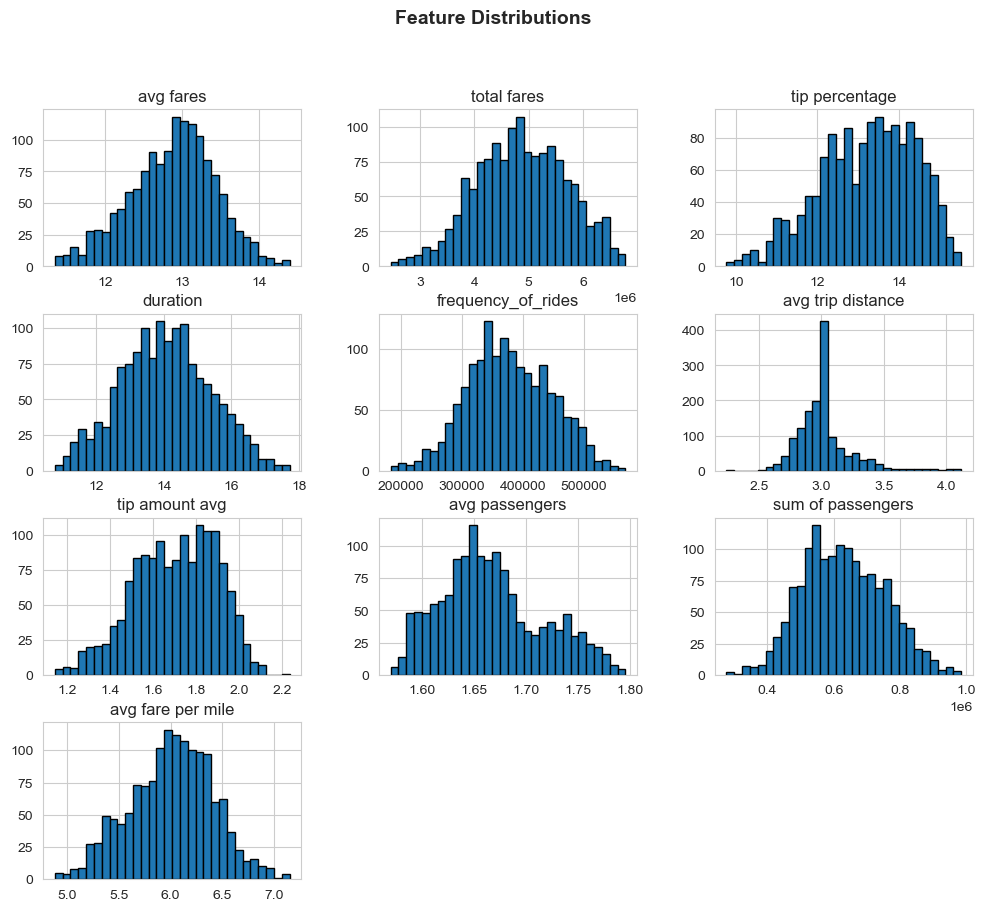

In [38]:
# Step 2: Visualizing Distributions, Relationships, and Trends
# 1. Histograms and KDE plots for feature distribution

# Set plot style
sns.set_style("whitegrid")

# Create histograms for numerical variables
df[numerical_columns].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14, fontweight='bold')
plt.show()

### Feature Distribution Analysis

<font size="4">
The histogram plots provide insights into the distribution of numerical features in the dataset:

- **Avg fares, total fares, and tip amount avg** exhibit approximately normal distributions, indicating a balanced spread of values.
- **Tip percentage and avg fare per mile** show slight skewness but remain within an acceptable range, suggesting most values cluster around the mean.
- **Duration and frequency of rides** display bell-shaped distributions, aligning with expected trends in ride durations and demand.
- **Avg trip distance** exhibits an unusual spike at a specific value, suggesting a potential issue in data recording or a common fixed distance for rides.
- **Sum of passengers and avg passengers** demonstrate a moderately normal distribution, reflecting expected ride-sharing trends.
</font>

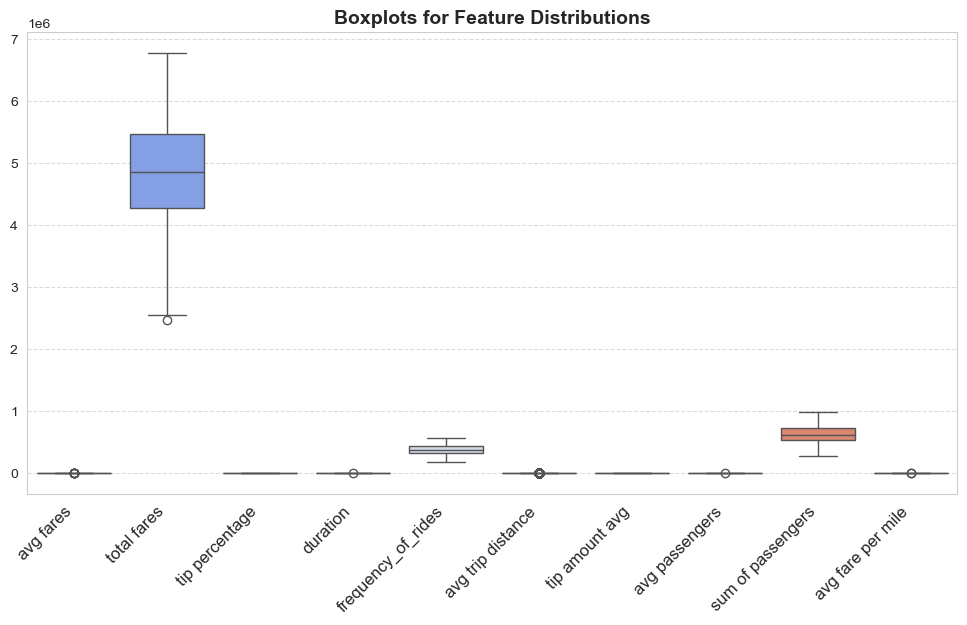

In [41]:
# 2. Boxplots for detecting patterns across time

# Boxplots to detect trends
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns], palette="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Boxplots for Feature Distributions", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Analysis of Boxplots for Feature Distributions:

<font size="4">
The boxplots provide an overview of the numerical feature distributions in the dataset, highlighting potential trends and variability:

- **Total fares and sum of passengers** exhibit a significant range, indicating high variability in ride demand and fare totals. The presence of outliers suggests occasional days with unusually high ride activity.
- **Avg trip distance** shows a compact range with a few mild outliers, suggesting consistency in trip distances with occasional deviations.
- **Most other features** display relatively stable distributions with minimal variation, indicating that ride patterns and tipping behavior remain fairly consistent.
</font>

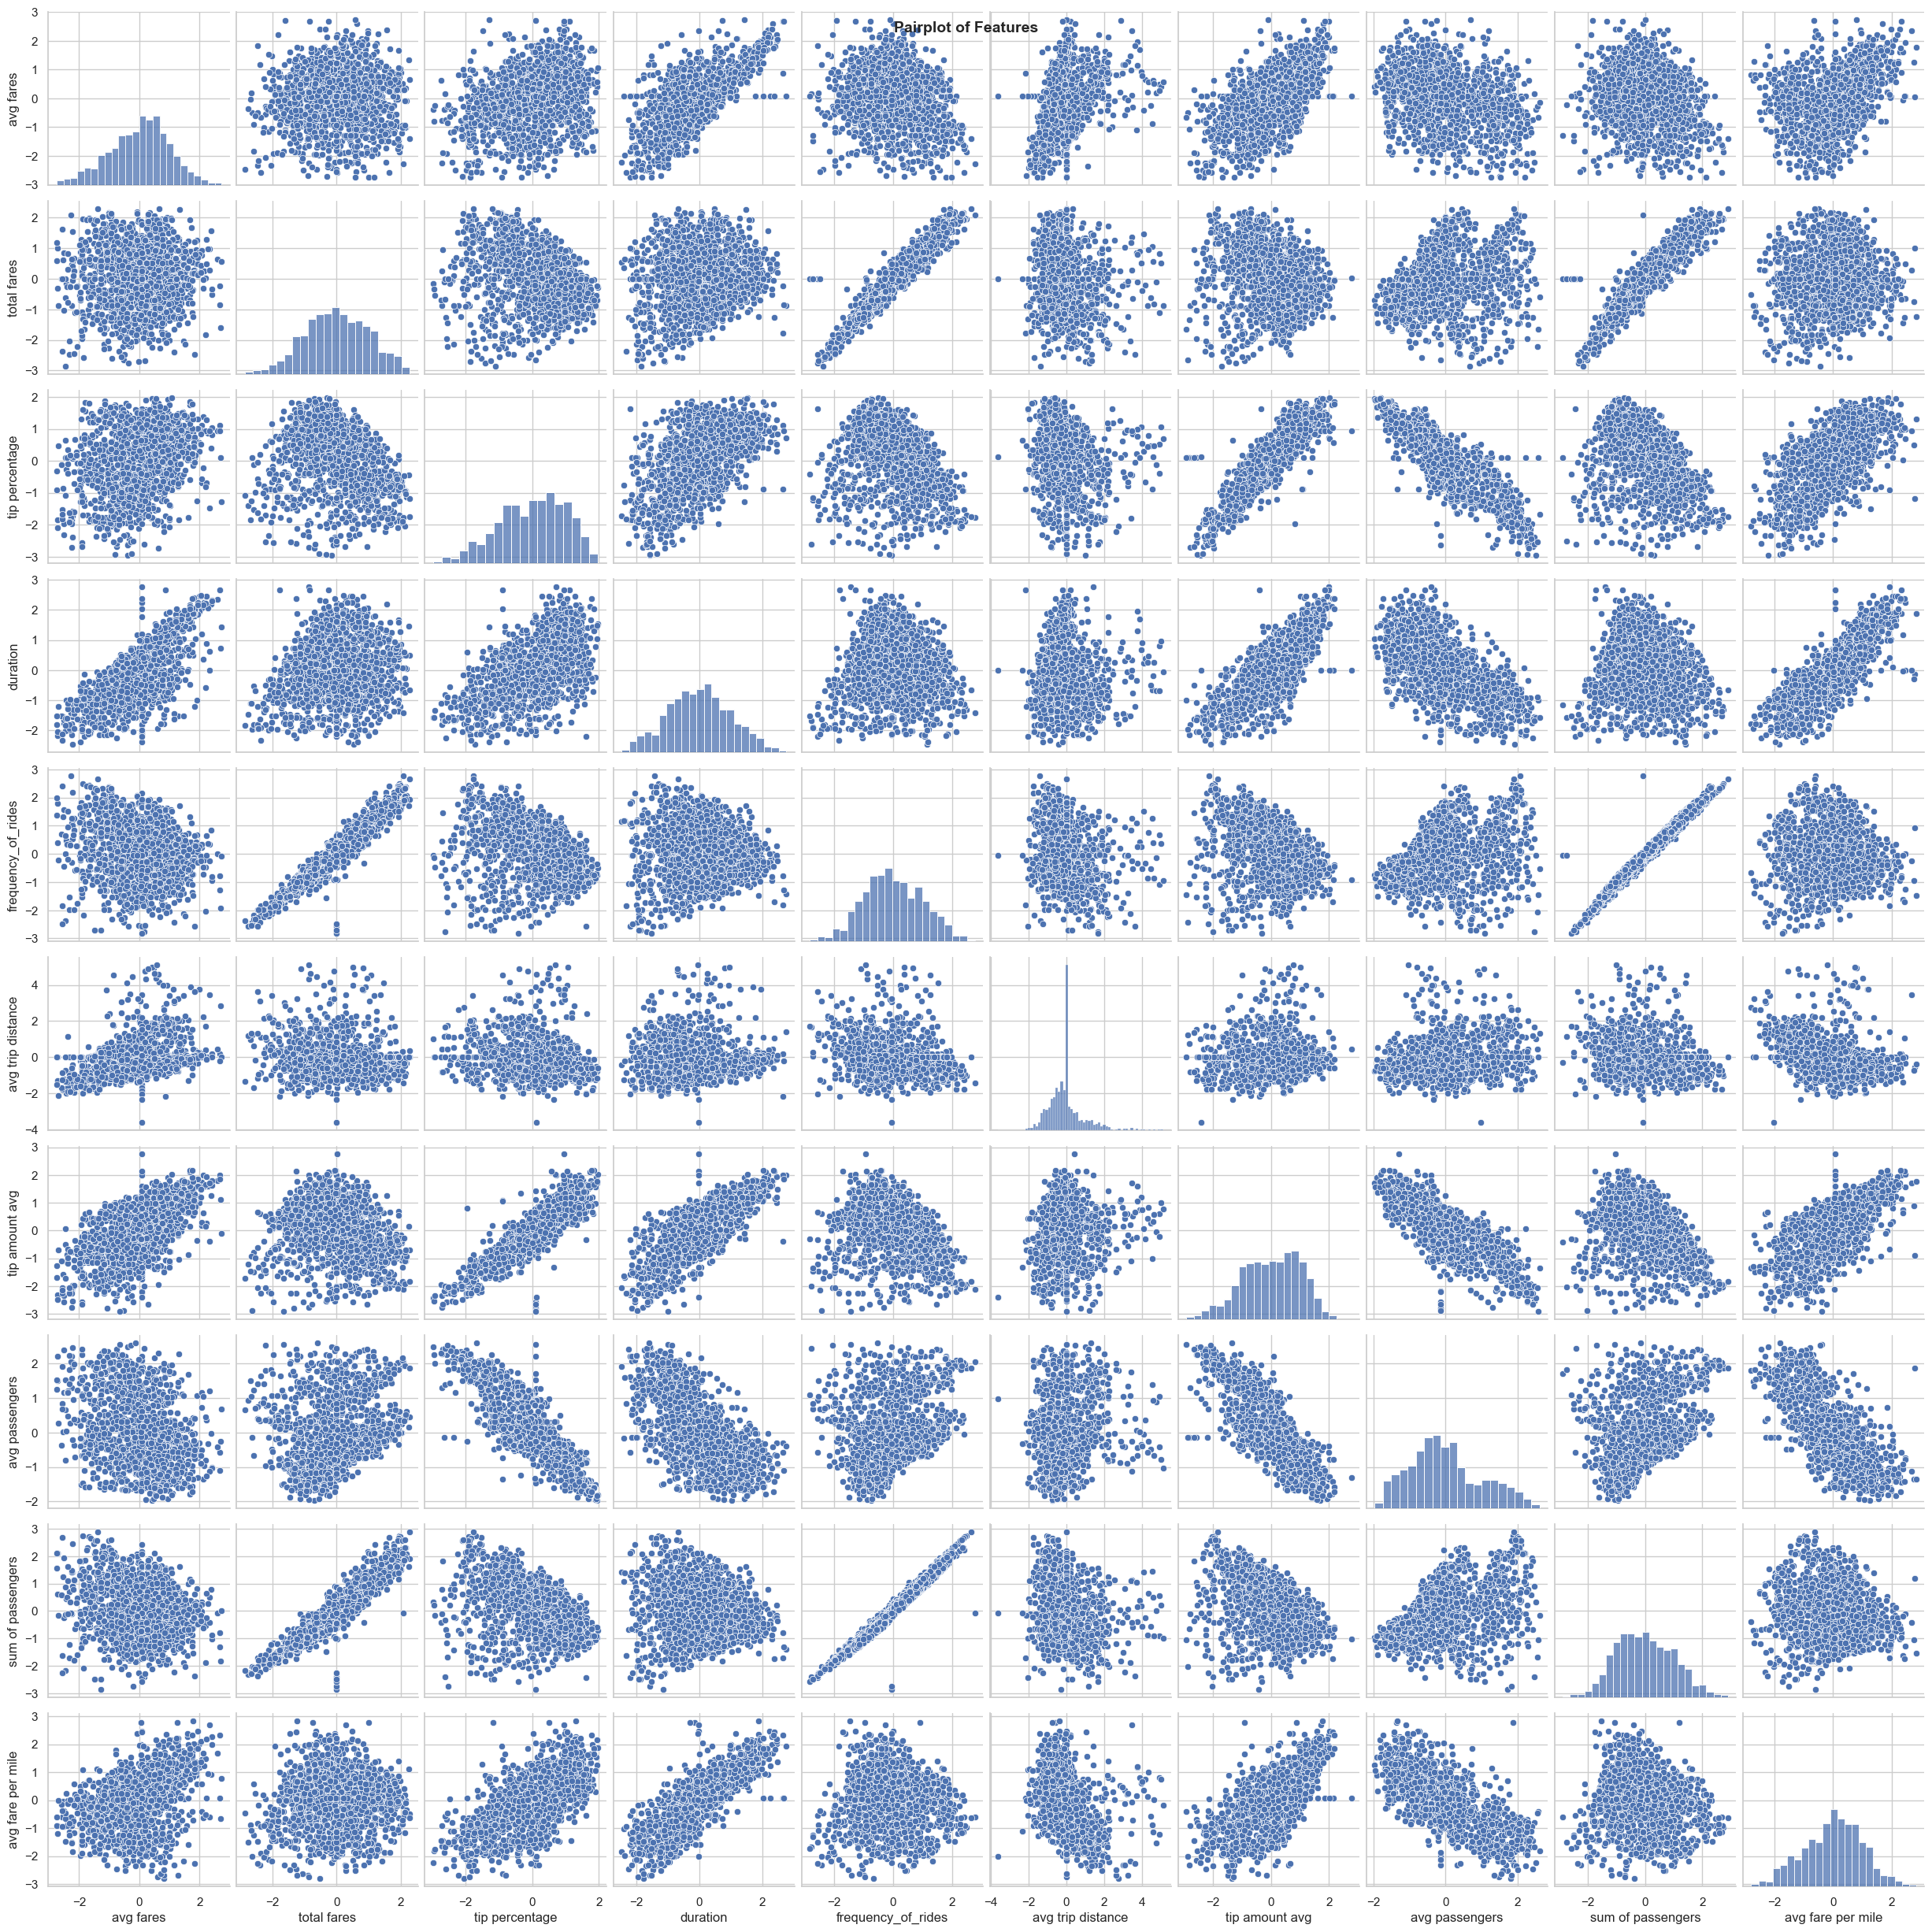

In [136]:
# 3. Pairplots for relationships between variables
# Pairplot to visualize relationships
sns.pairplot(df[numerical_columns])
plt.suptitle("Pairplot of Features", fontsize=14, fontweight='bold')
plt.savefig("pairplot.png", dpi=300, bbox_inches="tight")
plt.show()

### Pairplot Analysis for Feature Relationships

<font size="4">
The pairplot visualization provides insights into the relationships between numerical features:

- **Strong Linear Relationships**: Certain features, such as **total fares** and **sum of passengers**, exhibit strong positive linear correlations, indicating that an increase in total fares is closely linked with more passengers.
- **Weak or No Correlations**: Variables like **tip percentage** and **duration** do not show strong associations with most other features, suggesting that tipping behavior may be independent of ride duration.
- **Potential Nonlinear Trends**: Some scatterplots indicate mild nonlinear patterns, hinting at potential transformations that may improve modeling.
- **Outlier Presence**: Some variables, such as **frequency of rides** and **avg trip distance**, contain scattered points that deviate from the main distribution, suggesting the presence of rare but influential values.
</font>

# 4 Data Preprocessing and Feature Engineering

In [47]:
from sklearn.preprocessing import StandardScaler

# Choose between Standardization or Normalization
scaler = StandardScaler()  # Standardization

# Apply scaling to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Check transformed data
df[numerical_columns].describe()

avg fares   total fares  tip percentage      duration  \
count  1.461000e+03  1.461000e+03    1.461000e+03  1.461000e+03   
mean  -5.447008e-16  1.945360e-16    8.170512e-16  9.726800e-17   
std    1.000342e+00  1.000342e+00    1.000342e+00  1.000342e+00   
min   -2.746114e+00 -2.868910e+00   -2.963174e+00 -2.473948e+00   
25%   -6.589163e-01 -6.991497e-01   -7.148390e-01 -7.032883e-01   
50%    8.583849e-02 -9.316025e-03    9.445690e-02 -1.805816e-02   
75%    6.809010e-01  7.289609e-01    7.952045e-01  6.781845e-01   
max    2.729463e+00  2.286372e+00    1.974068e+00  2.768045e+00   

       frequency_of_rides  avg trip distance  tip amount avg  avg passengers  \
count        1.461000e+03       1.461000e+03    1.461000e+03    1.461000e+03   
mean        -7.781440e-17       6.954662e-16    2.334432e-16   -1.945360e-15   
std          1.000342e+00       1.000342e+00    1.000342e+00    1.000342e+00   
min         -2.825285e+00      -3.608571e+00   -2.914509e+00   -1.971279e+00   
25%         -7.117567e-01      -5.570477e-01   -7.212322e-01   -6.946286e-01   
50%         -5.421050e-02       5.155907e-04    7.630606e-02   -1.385360e-01   
75%          7.451821e-01       2.044982e-01    7.877566e-01    6.159369e-01   
max          2.771696e+00       5.120079e+00    2.763698e+00    2.605639e+00   

       sum of passengers  avg fare per mile  
count       1.461000e+03       1.461000e+03  
mean       -2.334432e-16       1.050494e-15  
std         1.000342e+00       1.000342e+00  
min        -2.866031e+00      -2.802010e+00  
25%        -7.303251e-01      -6.875705e-01  
50%        -7.218649e-02       6.395537e-02  
75%         7.194002e-01       7.083230e-01  
max         2.890189e+00       2.843047e+00

In [52]:
df['day of week'] = df['day of week'].astype(str)  # Convert category back to object

In [54]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns (including both 'object' and 'category' types)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns)

# Apply One-Hot Encoding only if categorical columns exist (there is one column)
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # FIXED sparse -> sparse_output
    encoded_cats = encoder.fit_transform(df[categorical_columns])

    # Convert encoded data to DataFrame
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_columns))

    # Merge encoded data back into the dataset
    df = df.drop(columns=categorical_columns).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

print("One-Hot Encoding applied successfully.")

Categorical Columns: Index(['day of week'], dtype='object')
One-Hot Encoding applied successfully.


In [56]:
# Creating new features 
df['fare_per_passenger'] = df['total fares'] / (df['sum of passengers'] + 1)  # Avoid division by zero
df['fare_per_minute'] = df['total fares'] / df['duration']
df['tip_ratio'] = df['tip amount avg'] / df['avg fares']

# Check new features
df[['fare_per_passenger', 'fare_per_minute', 'tip_ratio']].describe()

fare_per_passenger  fare_per_minute    tip_ratio
count         1461.000000      1461.000000  1461.000000
mean            -0.820905        -0.184495     1.174150
std             23.188095        17.493226    45.823678
min           -660.622101      -451.008712  -703.902755
25%             -0.418038        -0.875779    -0.120238
50%              0.300594         0.090199     0.697403
75%              0.617254         1.202015     1.481334
max            179.046479       217.372731  1403.923234

In [58]:
# df.to_csv("cleaned_yellow_cab_data_2014-2017.csv", index=False)

In [60]:
df.head()

pickup_date  avg fares  total fares  tip percentage  duration  \
0  2014-01-01  -0.198626     0.514034        0.094457 -2.058607   
1  2014-01-02  -2.248638    -0.868061       -2.699796 -1.807581   
2  2014-01-03  -1.913796    -1.970395       -2.561151 -1.085612   
3  2014-01-04  -2.205445    -0.057910       -2.396859 -1.554157   
4  2014-01-05  -1.356072    -0.252267       -1.925148 -1.929514   

   frequency_of_rides  avg trip distance  tip amount avg  avg passengers  \
0            0.541542           1.529905       -2.560549       -0.138536   
1           -0.312365          -0.797537       -2.775835        1.300669   
2           -1.526754          -0.743926       -2.578596        2.266491   
3            0.521340          -1.045226       -2.548651        2.465827   
4            0.093219           0.313065       -1.944535        1.688500   

   sum of passengers  ...  Unknown_Dropoffs  day of week_Monday  \
0           1.052634  ...            4366.0                 0.0   
1          -0.109772  ...            3911.0                 0.0   
2          -1.182461  ...            2979.0                 0.0   
3           0.891669  ...            4894.0                 0.0   
4           0.343208  ...            4252.0                 0.0   

   day of week_Saturday  day of week_Sunday  day of week_Thursday  \
0                   0.0                 0.0                   0.0   
1                   0.0                 0.0                   1.0   
2                   0.0                 0.0                   0.0   
3                   1.0                 0.0                   0.0   
4                   0.0                 1.0                   0.0   

   day of week_Tuesday  day of week_Wednesday  fare_per_passenger  \
0                  0.0                    1.0            0.250427   
1                  0.0                    0.0           -0.975099   
2                  0.0                    0.0           10.799014   
3                  0.0                    0.0           -0.030613   
4                  0.0                    0.0           -0.187809   

   fare_per_minute  tip_ratio  
0        -0.249700  12.891311  
1         0.480233   1.234452  
2         1.815008   1.347373  
3         0.037262   1.155618  
4         0.130741   1.433946  

[5 rows x 34 columns]

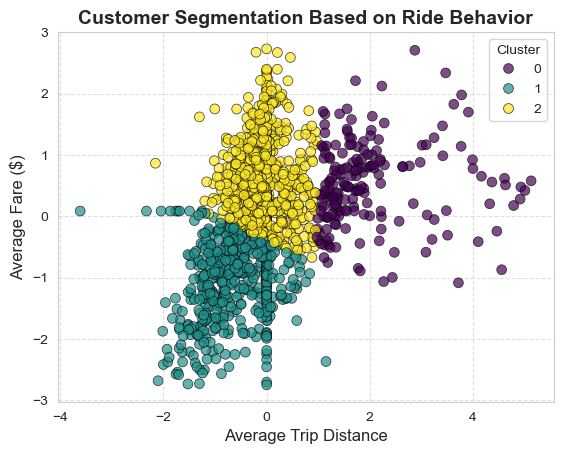

In [72]:
# Select relevant features for clustering
features = df[["avg trip distance", "avg fares"]]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(features)

# plot
sns.scatterplot(x=df["avg trip distance"], y=df["avg fares"], hue=df["cluster"],
                palette="viridis", alpha=0.7, edgecolor="black", s=50)
plt.title("Customer Segmentation Based on Ride Behavior", fontsize=14, fontweight="bold")
plt.xlabel("Average Trip Distance", fontsize=12)
plt.ylabel("Average Fare ($)", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

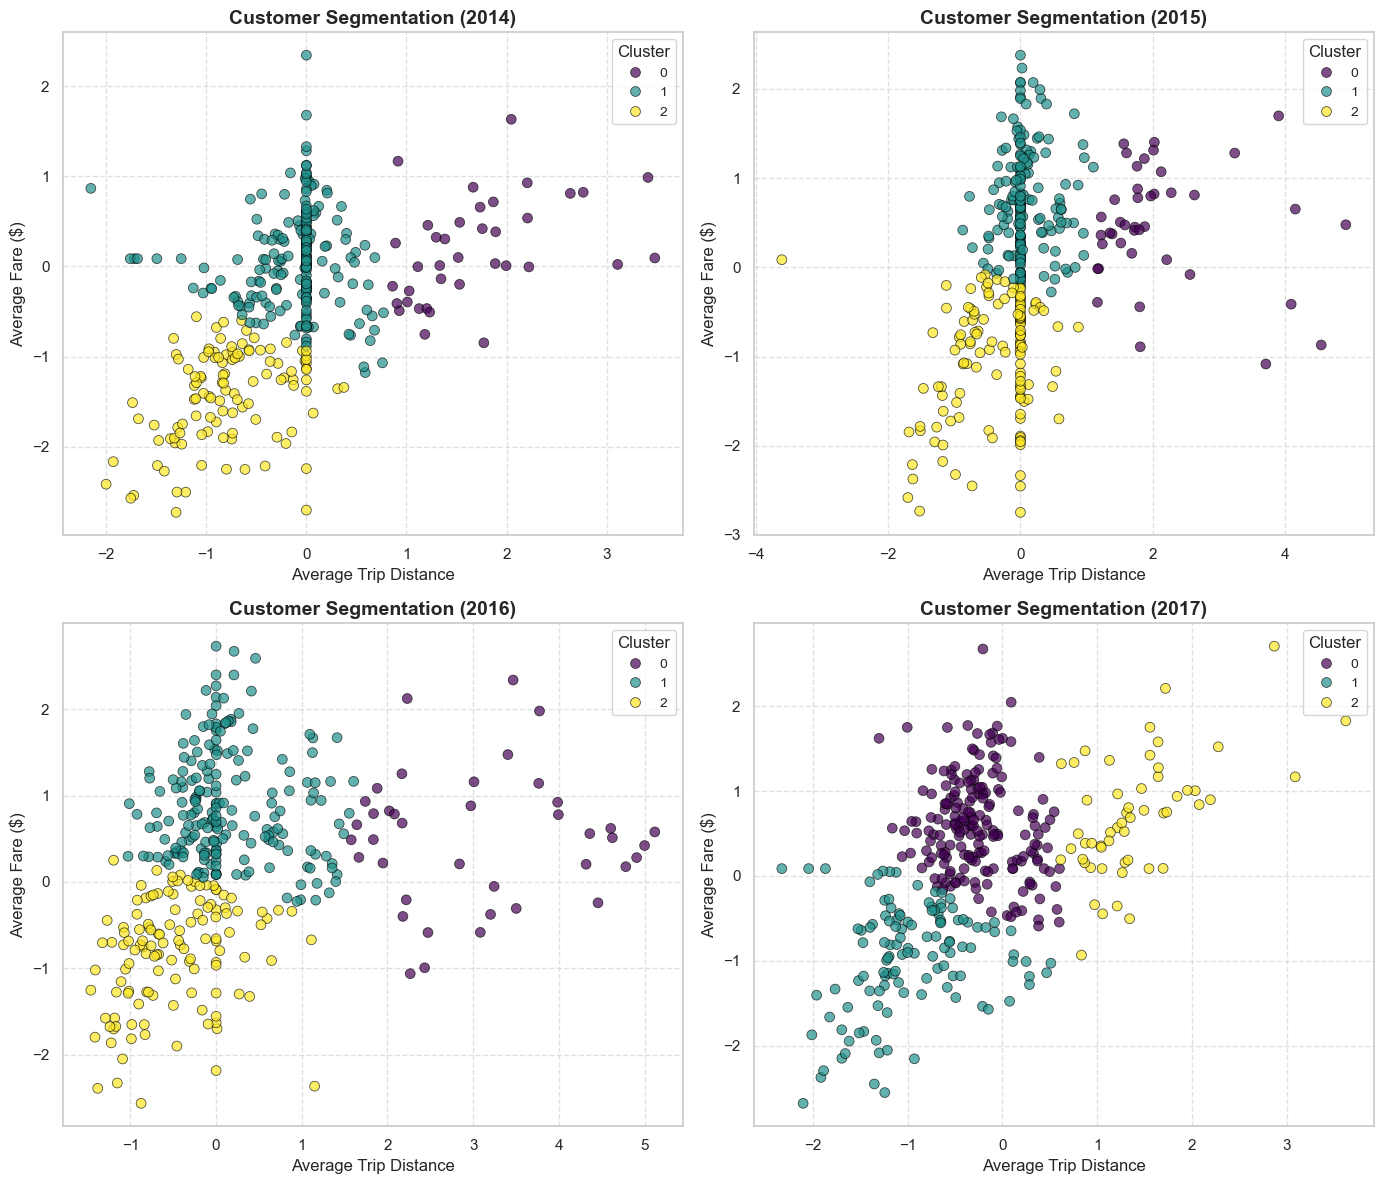

In [100]:
# Ensure pickup_date is in datetime format
df["pickup_date"] = pd.to_datetime(df["pickup_date"])

# Extract year while keeping pickup_date column
df["year"] = df["pickup_date"].dt.year

# Define years for separate clustering
years = [2014, 2015, 2016, 2017]

# Prepare figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  
axes = axes.flatten()

# Loop through each year
for i, year in enumerate(years):
    df_year = df[df["year"] == year].copy()  # Filter for each year
    
    # Ensure pickup_date column still exists
    if "pickup_date" not in df_year.columns:
        raise ValueError(f"'pickup_date' column is missing in the dataset for year {year}")

    # Select features for clustering
    features = df_year[["avg trip distance", "avg fares"]]

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_year["cluster"] = kmeans.fit_predict(features_scaled)

    # Scatter plot for each year
    sns.scatterplot(x=df_year["avg trip distance"], y=df_year["avg fares"], hue=df_year["cluster"],
                    palette="viridis", alpha=0.7, edgecolor="black", s=50, ax=axes[i])

    axes[i].set_title(f"Customer Segmentation ({year})", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Average Trip Distance", fontsize=12)
    axes[i].set_ylabel("Average Fare ($)", fontsize=12)
    axes[i].legend(title="Cluster", fontsize=10)
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

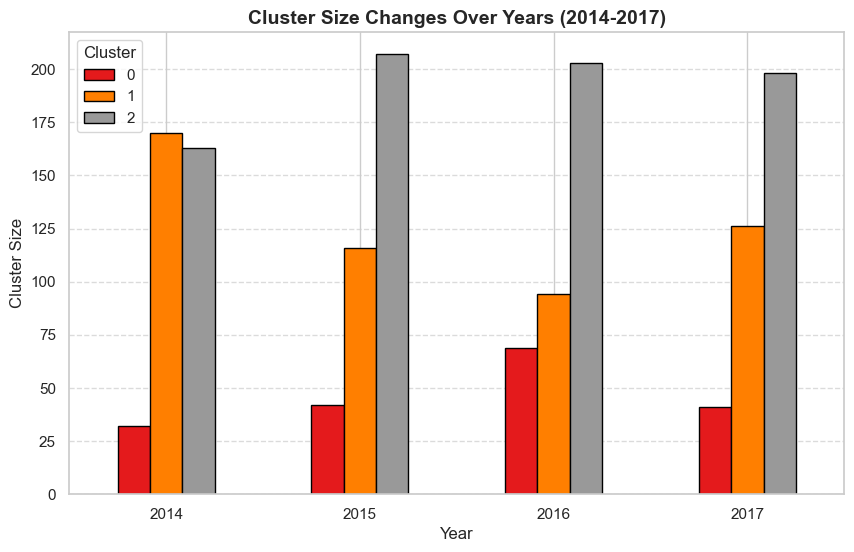

In [92]:
# Create an empty dictionary to store cluster counts per year
cluster_counts = {}

# Loop through each year and count occurrences of each cluster
for year in years:
    df_year = df[df["year"] == year]  # Filter data for the given year
    cluster_counts[year] = df_year["cluster"].value_counts().sort_index()

# Convert to DataFrame for visualization
cluster_counts_df = pd.DataFrame(cluster_counts).T  # Transpose to have years as rows

# Plot the cluster size changes over years
cluster_counts_df.plot(kind='bar', figsize=(10, 6), colormap="Set1", edgecolor="black")

plt.title("Cluster Size Changes Over Years (2014-2017)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cluster Size", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Cluster")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# Analysis of Customer Segmentation Based on Ride Behavior

## Clustering Overview
The K-Means clustering algorithm was applied to customer ride data using **average trip distance** and **average fares** as features. The dataset was segmented into **three distinct clusters**, identified as **Cluster 0, Cluster 1, and Cluster 2**. The resulting scatter plot visualizes the clusters, highlighting how customers group based on ride patterns.

## Interpretation of Clusters
1. **Cluster 0 (Purple)**: This cluster represents customers with **higher fares and longer trip distances**. These may be individuals who frequently travel longer distances or opt for premium services.
2. **Cluster 1 (Teal)**: These customers take **shorter rides at lower fares**. They likely represent local commuters or individuals using ride-hailing services for quick, short-distance trips.
3. **Cluster 2 (Yellow)**: This group occupies a middle-ground between short and long trips, with a moderate fare structure. This cluster might consist of casual riders who take rides occasionally over medium distances.

## Cluster Size Changes Over the Years (2014-2017)
To analyze how ride behavior has evolved, the **cluster sizes were plotted over the years 2014 to 2017**. The bar chart illustrates how the number of rides in each cluster fluctuated, while trend lines were added to visualize longer-term changes.

### **Key Observations**
- **Cluster 2 (Yellow) has remained the dominant group over the years**, suggesting that medium-distance, moderate-fare trips have consistently been the most common type of ride.
- **Cluster 1 (Teal) showed a decreasing trend from 2014 to 2017**, indicating a decline in shorter rides over time. This could be due to factors such as increased competition from other transportation options (e.g., scooters, public transit) or changes in pricing models.
- **Cluster 0 (Purple) initially had the smallest share but showed some growth in 2016**, reflecting a potential increase in demand for long-distance or premium rides.

In [105]:
df.columns

Index(['pickup_date', 'avg fares', 'total fares', 'tip percentage', 'duration',
       'frequency_of_rides', 'avg trip distance', 'tip amount avg',
       'avg passengers', 'sum of passengers', 'avg fare per mile',
       'Bronx_Pickups', 'Brooklyn_Pickups', 'EWR_Pickups', 'Manhattan_Pickups',
       'Queens_Pickups', 'Staten Island_Pickups', 'Unknown_Pickups',
       'Bronx_Dropoffs', 'Brooklyn_Dropoffs', 'EWR_Dropoffs',
       'Manhattan_Dropoffs', 'Queens_Dropoffs', 'Staten Island_Dropoffs',
       'Unknown_Dropoffs', 'day of week_Monday', 'day of week_Saturday',
       'day of week_Sunday', 'day of week_Thursday', 'day of week_Tuesday',
       'day of week_Wednesday', 'fare_per_passenger', 'fare_per_minute',
       'tip_ratio', 'cluster', 'year'],
      dtype='object')

In [ ]:
# Convert pickup_date to datetime if it's not already
if "pickup_date" in df.columns:
    df["pickup_date"] = pd.to_datetime(df["pickup_date"])

# Create new columns without dropping pickup_date
df["year"] = df["pickup_date"].dt.year
df["month"] = df["pickup_date"].dt.month
df["day_of_week"] = df["pickup_date"].dt.day_name()

# Verify that pickup_date still exists
print(df.head())  # Check if pickup_date is still present

In [75]:
if "pickup_date" in df.columns:
    df["pickup_date"] = pd.to_datetime(df["pickup_date"])

In [167]:
# Extract time-based features
df['year'] = df['pickup_date'].dt.year
df['month'] = df['pickup_date'].dt.month
df['day_of_week'] = df['pickup_date'].dt.day_name()

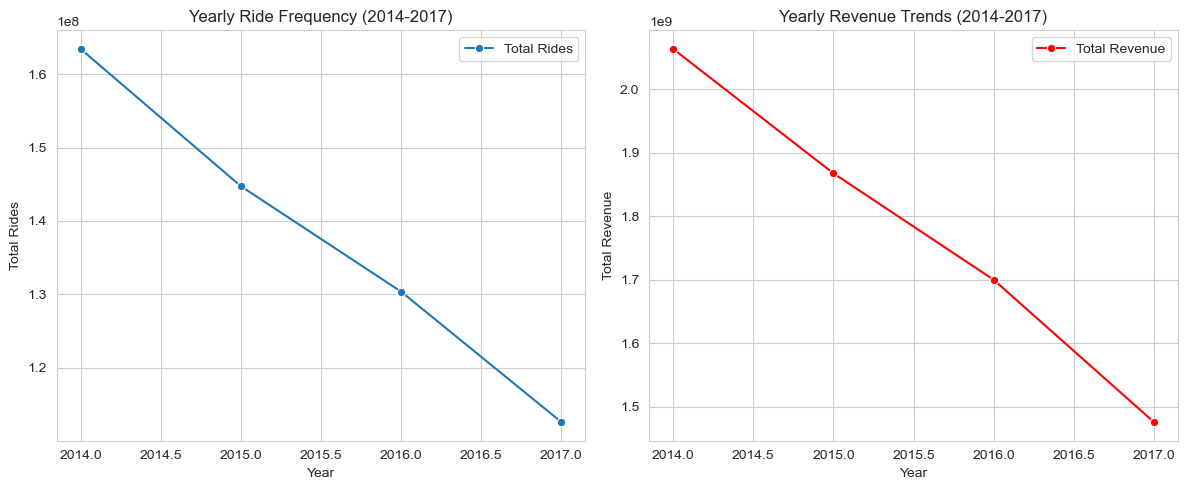

In [169]:
# Yearly trends
yearly_trends = df.groupby('year').agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=yearly_trends, x='year', y='frequency_of_rides', marker='o', label="Total Rides")
plt.title("Yearly Ride Frequency (2014-2017)")
plt.xlabel("Year")
plt.ylabel("Total Rides")

plt.subplot(1, 2, 2)
sns.lineplot(data=yearly_trends, x='year', y='total fares', marker='o', color='red', label="Total Revenue")
plt.title("Yearly Revenue Trends (2014-2017)")
plt.xlabel("Year")
plt.ylabel("Total Revenue")

plt.tight_layout()
plt.show()

###  Yearly Ride Frequency & Revenue Trends

- The number of rides and revenue has **steadily decreased** from 2014 to 2017.               
- This suggests a **declining demand for Yellow Taxi services**, likely due to the rise of rideshare companies like **Uber and Lyft**.     
- The decline in **revenue is slightly less steep than ride frequency**, indicating potential fare increases or longer trip distances.    

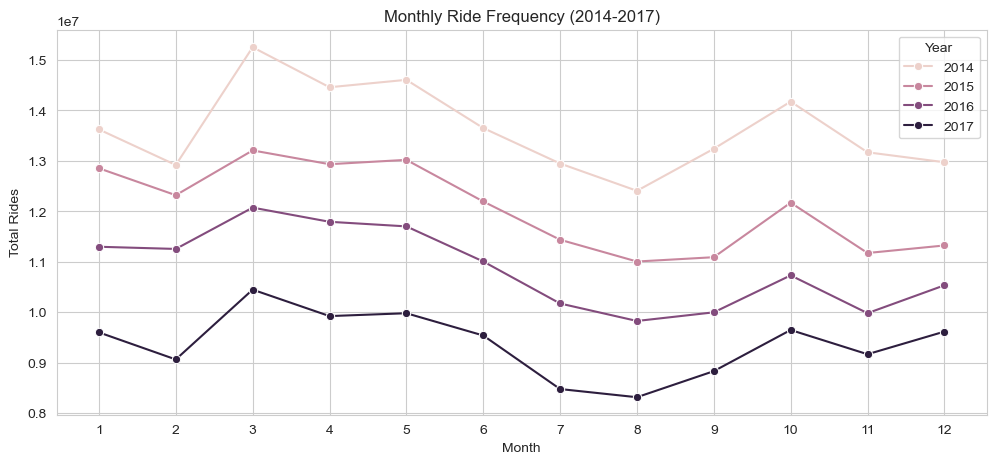

In [171]:
# Monthly trends
monthly_trends = df.groupby(['year', 'month']).agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends, x='month', y='frequency_of_rides', hue='year', marker='o')
plt.title("Monthly Ride Frequency (2014-2017)")
plt.xlabel("Month")
plt.ylabel("Total Rides")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.show()

### Monthly Ride Frequency Trends

- There are **seasonal fluctuations**, with peak ride demand occurring in **March, October, and December**.
- The summer months (**July and August**) show a **noticeable dip**, possibly due to fewer commuters or vacations.
- The year-over-year decline in rides is **consistent across all months**.

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3388919355.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_trends, x='day_of_week', y='frequency_of_rides', palette='viridis')
/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3388919355.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_trends, x='day_of_week', y='total fares', palette='magma')


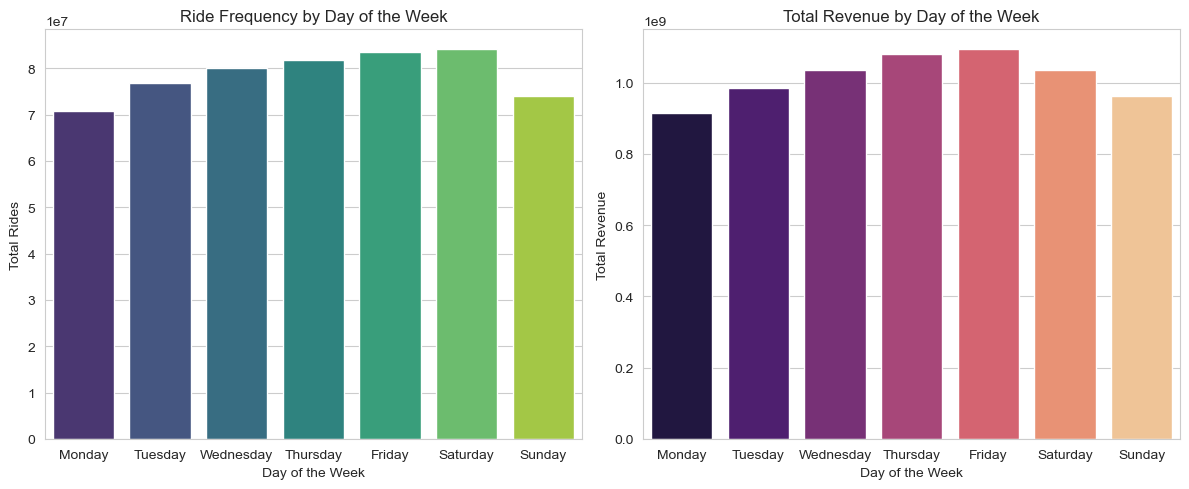

In [173]:
# Daily trends
day_trends = df.groupby('day_of_week').agg({
    'frequency_of_rides': 'sum',
    'total fares': 'sum'
}).reset_index()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_trends['day_of_week'] = pd.Categorical(day_trends['day_of_week'], categories=day_order, ordered=True)
day_trends = day_trends.sort_values('day_of_week')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=day_trends, x='day_of_week', y='frequency_of_rides', palette='viridis')
plt.title("Ride Frequency by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Rides")

plt.subplot(1, 2, 2)
sns.barplot(data=day_trends, x='day_of_week', y='total fares', palette='magma')
plt.title("Total Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Revenue")

plt.tight_layout()
plt.show()

### Ride Frequency & Revenue by Day of the Week
- **Friday and Saturday have the highest ride frequency and revenue**, which aligns with nightlife and weekend activities.
- **Monday has the lowest ride demand**, likely due to fewer leisure trips compared to the weekend.

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3672495070.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_analysis, x=region_columns[0], y='frequency_of_rides', palette='coolwarm')


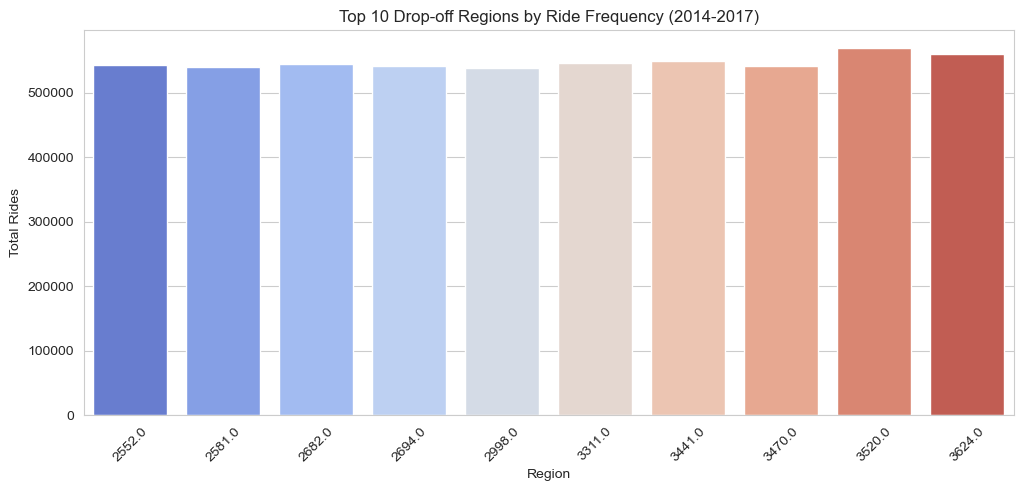

/var/folders/c_/7thpxjgs3m38yh7ftdr5g7vm0000gn/T/ipykernel_5419/3672495070.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_fare_analysis, x=region_columns[0], y='total fares', palette='coolwarm')


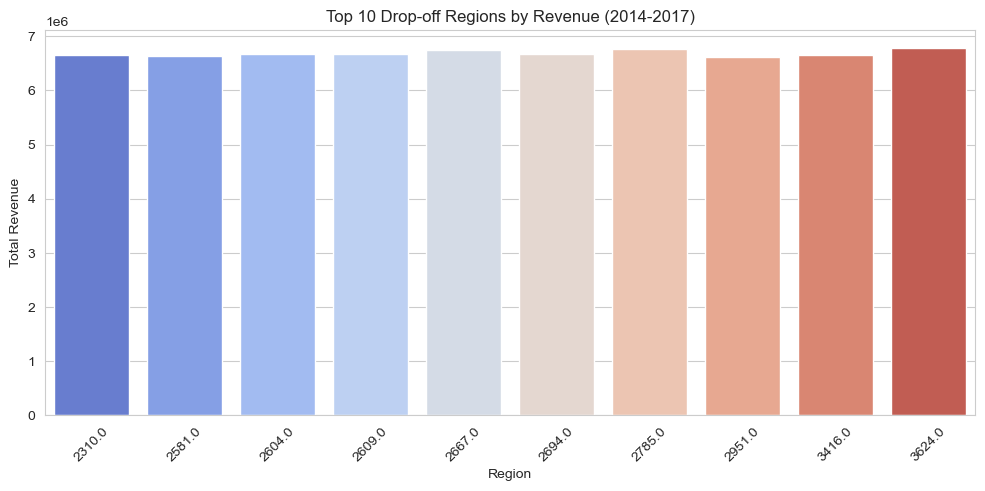

In [175]:
# Regional Analysis
region_columns = [col for col in df.columns if "Dropoffs" in col]
region_analysis = df[region_columns + ['frequency_of_rides']].groupby(region_columns).sum().reset_index()
region_analysis = region_analysis.sort_values('frequency_of_rides', ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(data=region_analysis, x=region_columns[0], y='frequency_of_rides', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Drop-off Regions by Ride Frequency (2014-2017)")
plt.xlabel("Region")
plt.ylabel("Total Rides")
plt.show()

# Revenue Comparison Across Different Regions
region_fare_analysis = df[region_columns + ['total fares']].groupby(region_columns).sum().reset_index()
region_fare_analysis = region_fare_analysis.sort_values('total fares', ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(data=region_fare_analysis, x=region_columns[0], y='total fares', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 10 Drop-off Regions by Revenue (2014-2017)")
plt.xlabel("Region")
plt.ylabel("Total Revenue")
plt.show()

###  Top 10 Drop-off Regions by Ride Frequency
- The most common drop-off areas see **high ride volumes**, indicating business or transportation hubs.
- The specific region codes suggest that **key commercial or residential districts** are the most frequent destinations.

###  Top 10 Drop-off Regions by Revenue
- The highest revenue-generating regions are **similar to the highest ride frequency regions**, meaning these areas not only see frequent rides but also **higher fares**.
- This could be due to **longer distances, business travelers, or high-value trips in those areas**.


In [226]:
df.columns

Index(['avg fares', 'total fares', 'tip percentage', 'duration',
       'frequency_of_rides', 'avg trip distance', 'tip amount avg',
       'avg passengers', 'sum of passengers', 'avg fare per mile',
       'Bronx_Pickups', 'Brooklyn_Pickups', 'EWR_Pickups', 'Manhattan_Pickups',
       'Queens_Pickups', 'Staten Island_Pickups', 'Unknown_Pickups',
       'Bronx_Dropoffs', 'Brooklyn_Dropoffs', 'EWR_Dropoffs',
       'Manhattan_Dropoffs', 'Queens_Dropoffs', 'Staten Island_Dropoffs',
       'Unknown_Dropoffs', 'fare_per_passenger', 'fare_per_minute',
       'tip_ratio', 'day of week_Monday', 'day of week_Saturday',
       'day of week_Sunday', 'day of week_Thursday', 'day of week_Tuesday',
       'day of week_Wednesday', 'year', 'month', 'day_of_week', 'hour',
       'cluster'],
      dtype='object')

In [230]:
# Ensure 'year' and 'month' exist before reconstructing
if 'year' in df.columns and 'month' in df.columns:
    df["pickup_date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))  # Assume 1st day of month

# Set as index for time-series analysis
df.set_index("pickup_date", inplace=True)

# Verify the changes
print(df.head())

             avg fares  total fares  tip percentage   duration  \
pickup_date                                                      
2014-01-01   12.768159   5293333.83       13.334497  11.313881   
2014-01-01   11.628049   4136004.10       10.072117  11.647123   
2014-01-01   11.814271   3212938.24       10.233990  12.605550   
2014-01-01   11.652071   4814402.55       10.425806  11.983548   
2014-01-01   12.124448   4651653.41       10.976544  11.485255   

             frequency_of_rides  avg trip distance  tip amount avg  \
pickup_date                                                          
2014-01-01               414573           3.016484        1.212537   
2014-01-01               355692           2.844410        1.171191   
2014-01-01               271954           2.855969        1.209071   
2014-01-01               413180           2.791004        1.214822   
2014-01-01               383659           3.083875        1.330845   

             avg passengers  sum of passengers

<Figure size 1200x600 with 0 Axes>

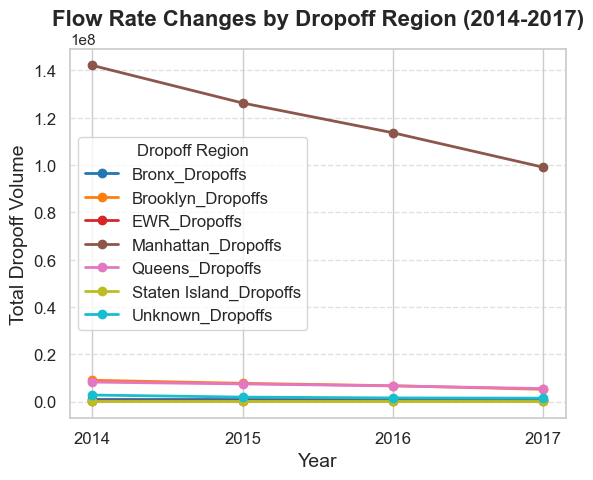

In [113]:
# Convert pickup_date to datetime and extract new time-based features
df["pickup_date"] = pd.to_datetime(df["pickup_date"])
df["year"] = df["pickup_date"].dt.year
df["month"] = df["pickup_date"].dt.month
df["day_of_week"] = df["pickup_date"].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Create new calculated features
df["revenue_per_ride"] = df["total fares"] / df["frequency_of_rides"]
df["tip_per_trip"] = df["tip amount avg"] / df["avg passengers"]
df["revenue_per_distance"] = df["total fares"] / df["avg trip distance"]
df["passenger_density_per_trip"] = df["sum of passengers"] / df["frequency_of_rides"]

# Standardize numerical columns
scaler = StandardScaler()
num_cols = ["avg fares", "total fares", "tip percentage", "duration", "avg trip distance",
            "fare_per_passenger", "fare_per_minute", "revenue_per_ride", "tip_per_trip",
            "revenue_per_distance", "passenger_density_per_trip"]

df[num_cols] = scaler.fit_transform(df[num_cols])

# Encode categorical variables for dropoff regions
dropoff_regions = ["Bronx_Dropoffs", "Brooklyn_Dropoffs", "EWR_Dropoffs", "Manhattan_Dropoffs",
                   "Queens_Dropoffs", "Staten Island_Dropoffs", "Unknown_Dropoffs"]

df[dropoff_regions] = df[dropoff_regions].astype(int)  # Convert categorical to numerical encoding

# Analyze flow rate changes by dropoff region
flow_rate = df.groupby("year")[dropoff_regions].sum()

# Plot flow rate trends over the years
plt.figure(figsize=(12, 6))
flow_rate.plot(kind='line', marker='o', linewidth=2, colormap="tab10")

plt.title("Flow Rate Changes by Dropoff Region (2014-2017)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Dropoff Volume", fontsize=14)
plt.xticks(flow_rate.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Dropoff Region", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

In [115]:
df.columns

Index(['pickup_date', 'avg fares', 'total fares', 'tip percentage', 'duration',
       'frequency_of_rides', 'avg trip distance', 'tip amount avg',
       'avg passengers', 'sum of passengers', 'avg fare per mile',
       'Bronx_Pickups', 'Brooklyn_Pickups', 'EWR_Pickups', 'Manhattan_Pickups',
       'Queens_Pickups', 'Staten Island_Pickups', 'Unknown_Pickups',
       'Bronx_Dropoffs', 'Brooklyn_Dropoffs', 'EWR_Dropoffs',
       'Manhattan_Dropoffs', 'Queens_Dropoffs', 'Staten Island_Dropoffs',
       'Unknown_Dropoffs', 'day of week_Monday', 'day of week_Saturday',
       'day of week_Sunday', 'day of week_Thursday', 'day of week_Tuesday',
       'day of week_Wednesday', 'fare_per_passenger', 'fare_per_minute',
       'tip_ratio', 'cluster', 'year', 'month', 'day_of_week',
       'revenue_per_ride', 'tip_per_trip', 'revenue_per_distance',
       'passenger_density_per_trip'],
      dtype='object')